# 課題①　あるクラウドファンディングが成功するかを事前に予測する

#### 必要なライブラリのインポート

In [39]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

#### データの読み込み、確認


In [40]:
df_ks =  pd.read_csv('ks-projects-201801.csv') 

display(df_ks.head())
df_ks.describe()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [41]:
df_ks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [42]:
#欠損値の数
df_ks.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [43]:
#ユニークな値の数を表示
df_ks.nunique()

ID                  378661
name                375764
category               159
main_category           15
currency                14
deadline              3164
goal                  8353
launched            378089
pledged              62130
state                    6
backers               3963
country                 23
usd pledged          95455
usd_pledged_real    106065
usd_goal_real        50339
dtype: int64

### 目的変数 stateについて調べる

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

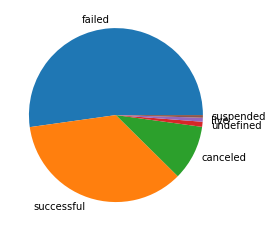

In [44]:
state_count = df_ks["state"].value_counts()
plt.pie(state_count, labels=state_count.index)
state_count

#### 今回は成功か失敗かを事前に予測するモデルの構築を目的とする。successful, failedのデータのみを扱うこととする。

In [45]:
#成功だけを抽出したDFと失敗だけを抽出したDF
df_ks_success = df_ks[df_ks['state']=='successful']
df_ks_failed =  df_ks[df_ks['state']=='failed']
#両方を結合
df_ks_2 = pd.concat([df_ks_success,df_ks_failed])
#再度stateの要素の個数を数える。
df_ks_2['state'].value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

In [46]:
df_ks_2.loc[df_ks_2['state'] == "successful", 'state'] = 1
df_ks_2.loc[df_ks_2['state'] == "failed", 'state'] = 0

backers, pledged, usd pledged, usd_pledged_realは実際の結果として集まった資金を表す値なので、事前予測においては使用不可と判断した。また、IDについては不要な情報であると判断した。

In [47]:
df_ks_2 = df_ks_2.drop(["ID", "pledged", "usd pledged", "usd_pledged_real", "backers"], axis=1)

### 量的変数の可視化

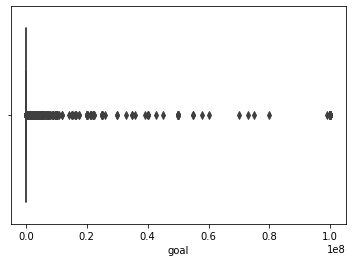

In [48]:
sns.boxplot(df_ks_2["goal"])

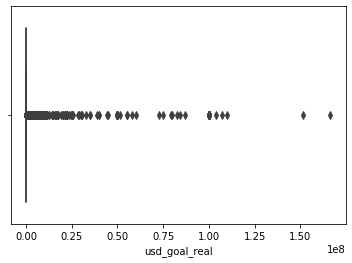

In [49]:
sns.boxplot(df_ks_2["usd_goal_real"])

両データともに0付近にデータが集中している。外れ値について検証する。goalの1.0e08付近に値が集中しているように思われるため、その部分を検証する。

In [50]:
df_goal_max = df_ks_2['goal'][df_ks_2['goal']>0.8*(10**8)] 
df_goal_max

23469     100000000.0
33084     100000000.0
47803      99000000.0
55009     100000000.0
72775     100000000.0
72990     100000000.0
77676     100000000.0
95513     100000000.0
118402    100000000.0
128835    100000000.0
141884    100000000.0
158459    100000000.0
160291    100000000.0
196531    100000000.0
211026    100000000.0
212541    100000000.0
213340    100000000.0
214787    100000000.0
222208    100000000.0
226161    100000000.0
243435    100000000.0
257518    100000000.0
259186    100000000.0
281020    100000000.0
338492    100000000.0
348139    100000000.0
367253    100000000.0
367928    100000000.0
369688    100000000.0
371478    100000000.0
Name: goal, dtype: float64

これらは正常な値である可能性もあるが、設定された上限の値を超えていて、便宜的に100000000.0となっている可能性がある。そのためgoalがこれらの値となっているデータについては除外することとする。

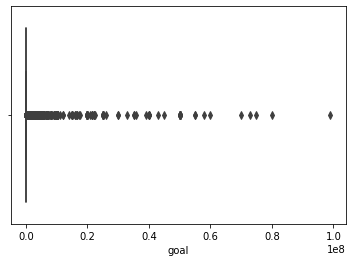

In [51]:
df_ks_2 = df_ks_2[df_ks_2['goal']<100000000]
sns.boxplot(df_ks_2["goal"])

usd-goal-realはgoalの通貨をそろえたものであるから、usd-goal-realを用いる方が適切であると考えられる。以下で標準化を行い、標準化したusd_goal_stdを予測に用いることとする。

In [52]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
df_ks_2["usd_goal_real_std"]=stdsc.fit_transform(df_ks_2[["usd_goal_real"]].values)


### 期間について　
#### launchからdeadlineまでの日数を変数deltaとして新たに追加した。こちらも標準化を行ったものを予測に用いる。

In [53]:
df_ks_2["launched"]= pd.to_datetime(df_ks_2["launched"])
df_ks_2["deadline"]= pd.to_datetime(df_ks_2["deadline"])
df_ks_2["delta"]=(df_ks_2["deadline"]-df_ks_2["launched"]).dt.days


In [54]:
df_ks_2["delta"].describe()

count    331646.000000
mean         32.953821
std          12.712159
min           0.000000
25%          29.000000
50%          29.000000
75%          35.000000
max          91.000000
Name: delta, dtype: float64

In [55]:
print(df_ks_2.dtypes)
df_ks_2.head()

name                         object
category                     object
main_category                object
currency                     object
deadline             datetime64[ns]
goal                        float64
launched             datetime64[ns]
state                         int64
country                      object
usd_goal_real               float64
usd_goal_real_std           float64
delta                         int64
dtype: object


,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,usd_goal_real_std,delta
5,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,1,US,50000.00,0.025405,34
6,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1,US,1000.00,-0.050121,19
11,Lisa Lim New CD!,Indie Rock,Music,USD,2013-04-08,12500.0,2013-03-09 06:42:58,1,US,12500.00,-0.032395,29
14,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,Games,GBP,2017-05-03,5000.0,2017-04-05 19:44:18,1,GB,6469.73,-0.041690,27
18,Mike Corey's Darkness & Light Album,Music,Music,USD,2012-08-17,250.0,2012-08-02 14:11:32,1,US,250.00,-0.051277,14


#### deltaの分布、外れ値について検証する

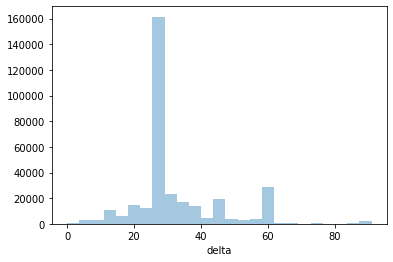

In [56]:
sns.distplot(df_ks_2['delta'], bins=25, kde=False,rug=False)

In [57]:
df_ks_2[df_ks_2["delta"]==0]

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,usd_goal_real_std,delta
12494,Interior Garden (1978),Film & Video,Film & Video,GBP,2016-06-15,130.0,2016-06-14 02:24:00,1,GB,185.73,-0.051376,0
23300,Poster: All 3D Printers Made,Art,Art,USD,2014-07-16,20.0,2014-07-15 15:20:08,1,US,20.00,-0.051631,0
34578,Björk Swan Dress T-Shirt,Conceptual Art,Art,USD,2012-02-17,180.0,2012-02-16 17:56:27,1,US,180.00,-0.051384,0
65731,Freshman Survival Guide,Publishing,Publishing,USD,2012-03-31,50.0,2012-03-30 22:11:20,1,US,50.00,-0.051585,0
70685,"""Insert Title Here"" a 24 hour comic day comic",Comics,Comics,USD,2016-10-02,20.0,2016-10-01 00:28:42,1,US,20.00,-0.051631,0
...,...,...,...,...,...,...,...,...,...,...,...,...
322948,[GLMG]Server Community,Video Games,Games,GBP,2014-10-02,4700.0,2014-10-01 19:59:35,0,GB,7551.17,-0.040023,0
352818,The ADHD Adventures of Jacob Book,Children's Books,Publishing,USD,2015-04-04,3500.0,2015-04-03 01:00:43,0,US,3500.00,-0.046267,0
357036,Recording New Composition in Ireland,Classical Music,Music,USD,2017-06-22,1500.0,2017-06-21 18:59:18,0,US,1500.00,-0.049350,0
360244,Getting down to earth! Project 1 - ESCAPING FE...,Fine Art,Photography,USD,2014-06-13,5550.0,2014-06-12 01:48:03,0,US,5550.00,-0.043107,0


In [58]:
df_ks_2[df_ks_2["delta"]==df_ks_2["delta"].max()]

,name,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,usd_goal_real_std,delta
85716,CanStar LLC Kickstarts Fundraising for 'Vincen...,Theater,Theater,USD,2011-04-02,7000.0,2010-12-31 18:12:36,1,US,7000.0,-0.040872,91
88090,Traditions Build Winners as the Snipe Class tu...,Documentary,Film & Video,USD,2011-03-31,7500.0,2010-12-29 23:22:08,1,US,7500.0,-0.040102,91
150277,Misisipi Mike Wolf's 2nd Album - Enjoy Irrespo...,Country & Folk,Music,USD,2011-04-02,1500.0,2010-12-31 10:05:54,1,US,1500.0,-0.049350,91
170950,Cinema41,Film & Video,Film & Video,USD,2011-06-22,500.0,2011-03-22 23:58:12,1,US,500.0,-0.050891,91
243386,Angie McClure's new album,Indie Rock,Music,USD,2011-04-04,5000.0,2011-01-02 07:39:52,1,US,5000.0,-0.043955,91
22618,Fair Trade Fashion by SET Boutique,Fashion,Fashion,USD,2011-04-04,7000.0,2011-01-02 20:21:23,0,US,7000.0,-0.040872,91
38476,TRI TOUCH MUSIC KIOSK,Technology,Technology,USD,2011-06-15,65000.0,2011-03-15 23:40:04,0,US,65000.0,0.048526,91
61014,A Somewhat Secret Place: Disability and Art,Art,Art,USD,2011-06-21,10000.0,2011-03-21 23:49:31,0,US,10000.0,-0.036248,91
67868,"Men Who Dance With Men, Photographic Documentary",Photography,Photography,USD,2011-04-03,12000.0,2011-01-01 15:02:54,0,US,12000.0,-0.033166,91
74196,SmoothnFusion Jazz Comedy Album,Jazz,Music,USD,2011-04-01,12500.0,2010-12-30 00:53:47,0,US,12500.0,-0.032395,91


#### delta=0となっているデータについて実際に期間が一日未満であったことを確認した。deltaの最大値が91日となっているデータが多いが、クラウドファンディングの期間の最大が30日間であったと思われ、問題ないと判断した。
#### 以下標準化を行う。

In [59]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
df_ks_2["delta_std"]=stdsc.fit_transform(df_ks_2[["delta"]].values)

#### ここまでの処理を行ったデータについて一旦変数の相関係数を調べる

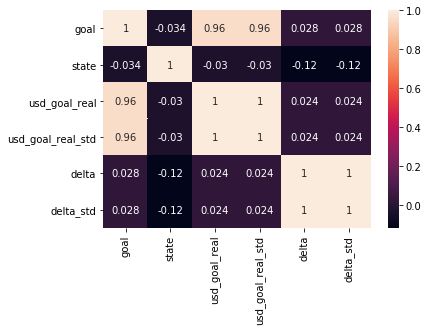

In [60]:
sns.heatmap(df_ks_2.corr(), annot=True)
plt.ylim(6, 0)
plt.show()

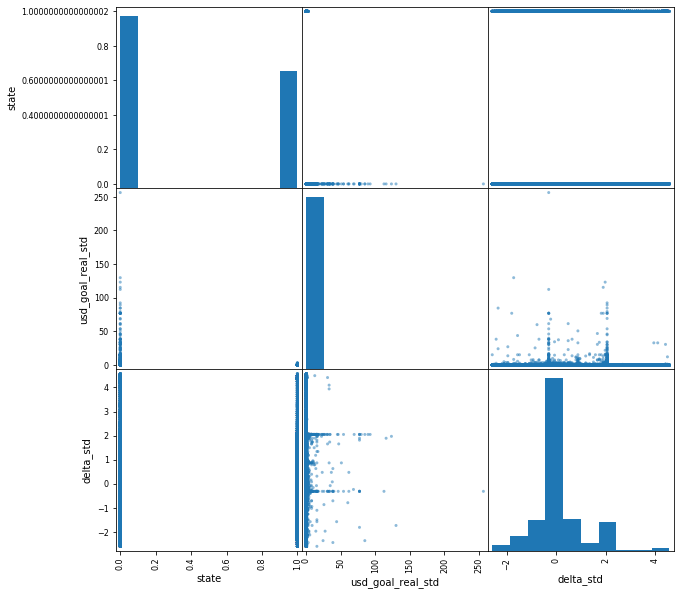

In [61]:
pd.plotting.scatter_matrix(df_ks_2[['state', 'usd_goal_real_std', 'delta_std']], figsize=(10,10))
plt.show()

goal, deltaともに目的変数stateと関係があるように思われるが、相関係数の値には表れていないようである。


### カテゴリーについて
#### 各カテゴリーごとの成功確率を求める。

main_category  state
Art            0        14128
               1        11510
Comics         0         4035
               1         5842
Crafts         0         5703
               1         2115
Dance          0         1235
               1         2338
Design         0        14814
               1        10550
Fashion        0        14181
               1         5593
Film & Video   0        32892
               1        23623
Food           0        15968
               1         6085
Games          0        16001
               1        12518
Journalism     0         3136
               1         1012
Music          0        21752
               1        24197
Photography    0         6384
               1         3305
Publishing     0        23144
               1        12300
Technology     0        20609
               1         6434
Theater        0         3708
               1         6534
Name: state, dtype: int64

main_category
Art             0.448943
Comics          0.591475
Crafts          0.270530
Dance           0.654352
Design          0.415944
Fashion         0.282846
Film & Video    0.417995
Food            0.275926
Games           0.438935
Journalism      0.243973
Music           0.526606
Photography     0.341108
Publishing      0.347026
Technology      0.237917
Theater         0.637961
Name: state, dtype: float64

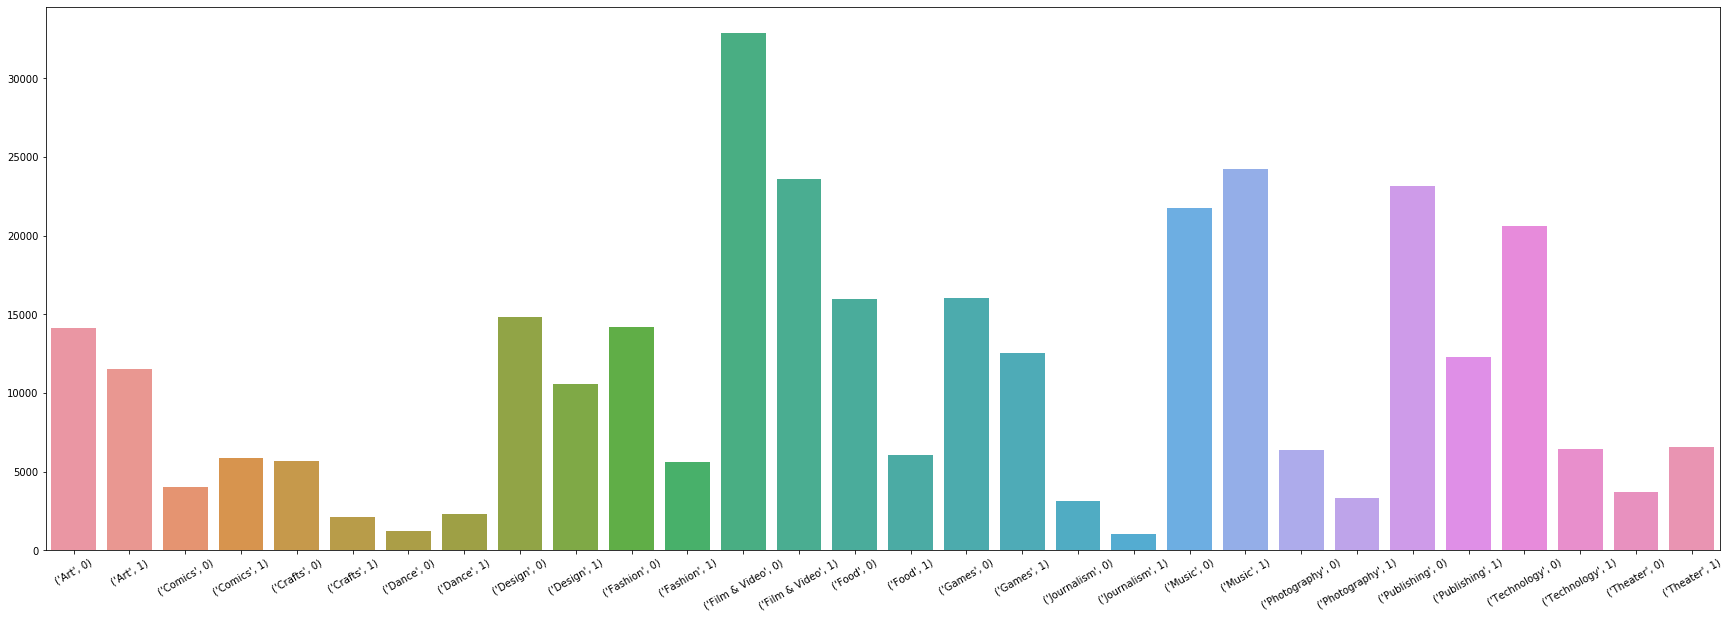

In [62]:
data_count_main_category = df_ks_2.groupby(["main_category","state"])["state"].count()
plt.figure(figsize=(30,10))
g = sns.barplot(data_count_main_category.keys(), data_count_main_category.values)
g.set_xticklabels(data_count_main_category.keys(),rotation=30)
display(data_count_main_category)
df_ks_2.groupby(["main_category"])["state"].mean()


In [63]:
data_count_category = df_ks_2.groupby(["category","state"])["state"].count()
display(data_count_category)
df_ks_2.groupby(["category"])["state"].mean()

category     state
3D Printing  0         326
             1         242
Academic     0         589
             1         188
Accessories  0        1667
                      ... 
World Music  1         922
Young Adult  0         538
             1         172
Zines        0         176
             1         179
Name: state, Length: 318, dtype: int64

category
3D Printing    0.426056
Academic       0.241956
Accessories    0.391606
Action         0.172581
Animals        0.275109
                 ...   
Woodworking    0.275992
Workshops      0.337838
World Music    0.475258
Young Adult    0.242254
Zines          0.504225
Name: state, Length: 159, dtype: float64

#### カテゴリーによって成功確率は異なっているように思われる。カテゴリーの種類が多いため、予測ではメインカテゴリーのみを扱うこととする。

In [64]:
df_ks_2=pd.get_dummies(df_ks_2, columns=['main_category'])

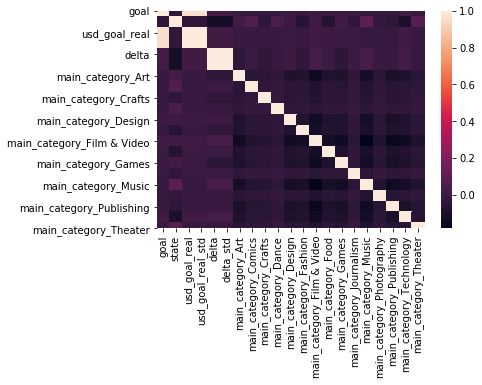

In [65]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ks_2.corr(), annot=False)
plt.show()

## currency, countrryについて

currency  state
AUD       0          4609
          1          2011
CAD       0          8236
          1          4137
CHF       0           464
          1           187
DKK       0           567
          1           362
EUR       0         10494
          1          3882
GBP       0         17394
          1         12081
HKD       0           261
          1           216
JPY       0            16
          1             7
MXN       0          1014
          1           396
NOK       0           420
          1           163
NZD       0           826
          1           448
SEK       0          1000
          1           509
SGD       0           276
          1           178
USD       0        152113
          1        109379
Name: state, dtype: int64

currency
AUD    0.303776
CAD    0.334357
CHF    0.287250
DKK    0.389666
EUR    0.270033
GBP    0.409873
HKD    0.452830
JPY    0.304348
MXN    0.280851
NOK    0.279588
NZD    0.351648
SEK    0.337309
SGD    0.392070
USD    0.418288
Name: state, dtype: float64

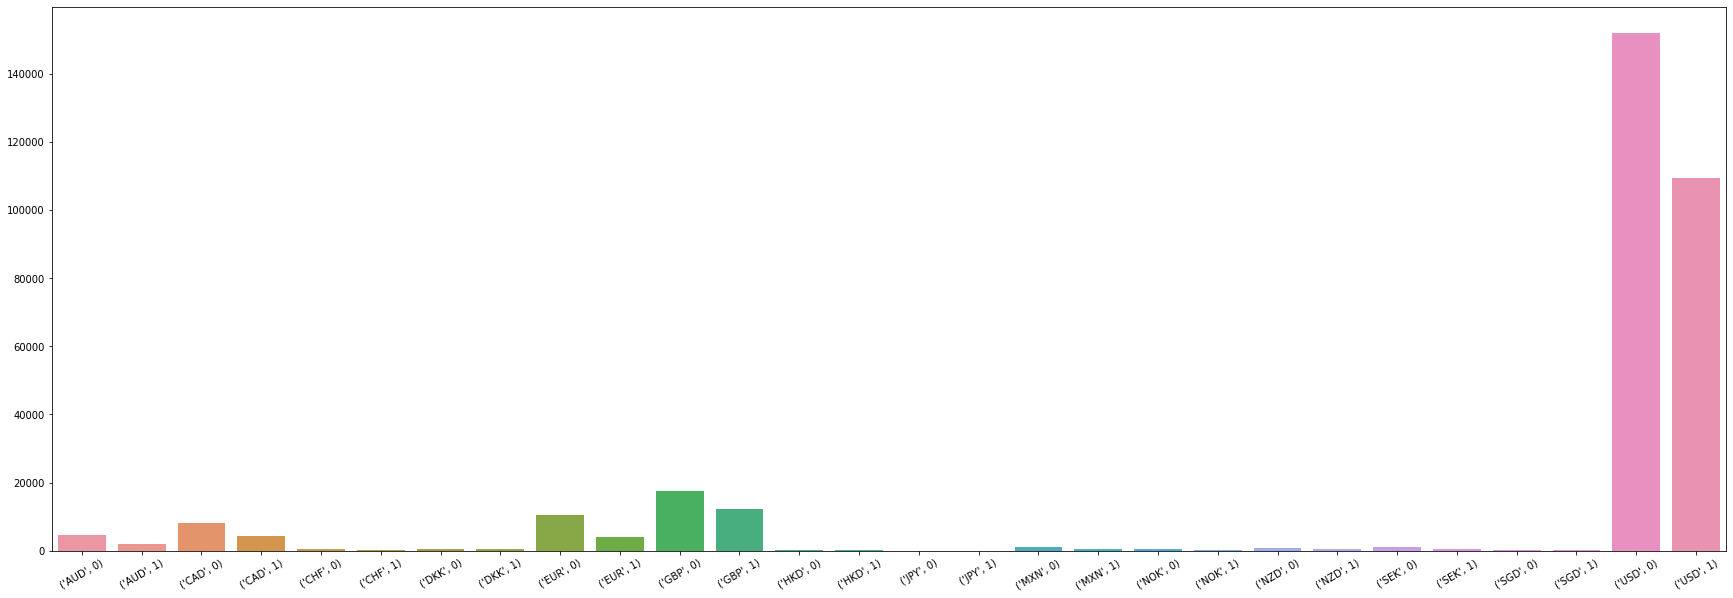

In [66]:
data_count_currency = df_ks_2.groupby(["currency","state"])["state"].count()
plt.figure(figsize=(30,10))
g = sns.barplot(data_count_currency.keys(),data_count_currency.values)
g.set_xticklabels(data_count_currency.keys(),rotation=30)
display(data_count_currency)
df_ks_2.groupby(["currency"])["state"].mean()


#### 通貨による違いが見られるため、ダミー変数を追加する。

In [67]:
df_ks_2=pd.get_dummies(df_ks_2, columns=['currency'])

country  state
AT       0           378
         1           107
AU       0          4605
         1          2010
BE       0           371
         1           152
CA       0          8234
         1          4134
CH       0           464
         1           187
DE       0          2498
         1           937
DK       0           566
         1           360
ES       0          1381
         1           492
FR       0          1611
         1           908
GB       0         17386
         1         12067
HK       0           261
         1           216
IE       0           476
         1           207
IT       0          1930
         1           439
JP       0            16
         1             7
LU       0            38
         1            19
MX       0          1014
         1           396
N,0"     0           105
         1           105
NL       0          1794
         1           617
NO       0           419
         1           162
NZ       0           826
         1

country
AT      0.220619
AU      0.303855
BE      0.290631
CA      0.334250
CH      0.287250
DE      0.272780
DK      0.388769
ES      0.262680
FR      0.360461
GB      0.409704
HK      0.452830
IE      0.303075
IT      0.185310
JP      0.304348
LU      0.333333
MX      0.280851
N,0"    0.500000
NL      0.255910
NO      0.278830
NZ      0.351648
SE      0.337533
SG      0.392070
US      0.418224
Name: state, dtype: float64

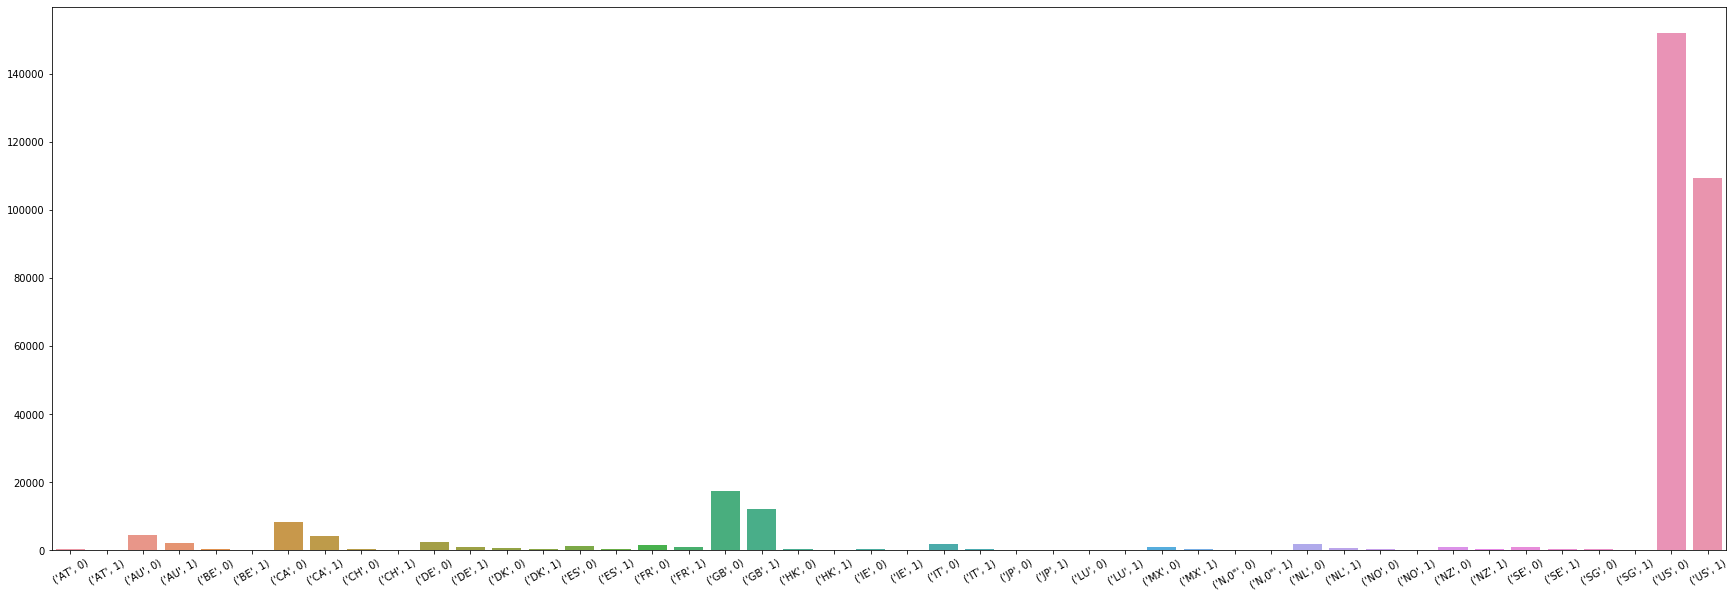

In [68]:
data_count_coutnry = df_ks_2.groupby(["country","state"])["state"].count()
plt.figure(figsize=(30,10))
g = sns.barplot(data_count_coutnry.keys(), data_count_coutnry.values)
g.set_xticklabels(data_count_coutnry.keys(),rotation=30)
display(data_count_coutnry)
df_ks_2.groupby(["country"])["state"].mean()

 国、通貨による成功確率の違いは見られたが、データ数が少ない国が多く、信頼性が高くないと判断した。

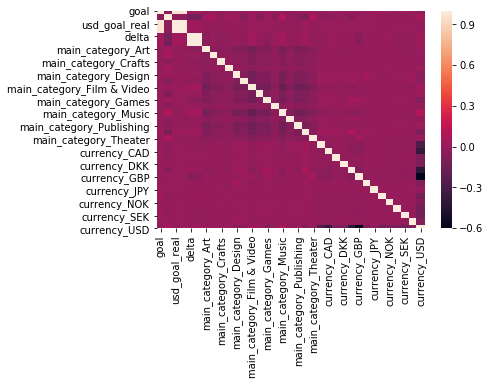

In [69]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_ks_2.corr(), annot=False)
plt.show()

## 予測モデルの構築

In [70]:
df_ks_2.head()

,name,category,deadline,goal,launched,state,country,usd_goal_real,usd_goal_real_std,delta,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
5,Monarch Espresso Bar,Restaurants,2016-04-01,50000.0,2016-02-26 13:38:27,1,US,50000.00,0.025405,34,...,0,0,0,0,0,0,0,0,0,1
6,Support Solar Roasted Coffee & Green Energy! ...,Food,2014-12-21,1000.0,2014-12-01 18:30:44,1,US,1000.00,-0.050121,19,...,0,0,0,0,0,0,0,0,0,1
11,Lisa Lim New CD!,Indie Rock,2013-04-08,12500.0,2013-03-09 06:42:58,1,US,12500.00,-0.032395,29,...,0,0,0,0,0,0,0,0,0,1
14,Tombstone: Old West tabletop game and miniatur...,Tabletop Games,2017-05-03,5000.0,2017-04-05 19:44:18,1,GB,6469.73,-0.041690,27,...,0,1,0,0,0,0,0,0,0,0
18,Mike Corey's Darkness & Light Album,Music,2012-08-17,250.0,2012-08-02 14:11:32,1,US,250.00,-0.051277,14,...,0,0,0,0,0,0,0,0,0,1


#### nameは予測に大きく関係していないと考えられるため、今回は除外した。これまでの考察から、まずは usd_goal_std, currencyおよび main_categoryのダミー変数, delta_std, で予測を行うこととした。

In [71]:
X = df_ks_2.drop(["state", "launched", "country", "usd_goal_real", "name", "category", "deadline", "goal","delta"], axis=1)
y = df_ks_2["state"]
X.head()

,usd_goal_real_std,delta_std,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,...,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
5,0.025405,0.082298,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
6,-0.050121,-1.097677,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
11,-0.032395,-0.311027,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
14,-0.041690,-0.468357,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
18,-0.051277,-1.491002,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### ロジスティック回帰で予測

In [72]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 

In [73]:
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, )
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
w = clf.coef_

print(w0)
print(w)

-0.7911444395968981
[[-9.36169194 -0.1724347   0.05283223  0.66784664 -0.82273296  0.93405156
   0.07856073 -0.62141084  0.10405136 -0.57951174  0.11167127 -0.76256111
   0.36447128 -0.32092407 -0.40994077 -0.42816875  0.84062073 -0.26570295
  -0.11236926 -0.0636167   0.12985211 -0.21715004  0.14217398  0.51593587
  -0.31763854 -0.50624405 -0.35325699 -0.04794968 -0.12087606  0.20784985
   0.21784802]]


#### 結果の表示

In [74]:
# ラベルを予測
y_est = clf.predict(X)

# 確率値を得る
y_est_proba = clf.predict_proba(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 

# 正答率を表示
print('正答率 = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)

print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[1]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[1]))

対数尤度 = -208320.657
正答率 = 64.681%
適合率（Precision） = 59.223%
再現率（Recall） = 40.315%
F1値（F1-score） = 47.974%


In [75]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])

conf_mat

,予測 = failed,予測 = successful
正解 = failed,160506,37184
正解 = successful,79951,54005


#### 予測モデルの構築が完了した。今のところ訓練データにおいてもあまり精度が良いとは言えないが、今後は汎化性能の検証、ロジスティック回帰以外のモデルの検証、今回除外した変数の活用を行っていきたい。